In [1]:
import numpy as np
import pandas as pd
import torch
from torch import nn

from config.experiment_config import ExperimentConfig
from ipsqt.utils.data import read_csv

config = ExperimentConfig()

In [2]:
data = read_csv(config.PATH_OUTPUT, config.DF_FILENAME)
data

,CAPE,STP,DIL,IR,_MKT,MKT_Factor
date,,,,,,
1989-04-09,0.000871,-0.363,-0.010312,0.001711,0.140409,0.138698
1989-04-16,0.013892,-0.284,-0.010645,0.001674,0.198562,0.196888
1989-04-23,0.024775,-0.304,-0.010879,0.001680,0.229547,0.227867
1989-04-30,0.003985,-0.231,-0.010801,0.001635,0.226966,0.225331
1989-05-07,-0.010056,-0.082,-0.005691,0.001639,0.241845,0.240206
...,...,...,...,...,...,...
2024-04-07,-0.010370,-0.417,-0.006858,0.001043,0.289452,0.288409
2024-04-14,-0.017253,-0.447,-0.007552,0.001047,0.256895,0.255848
2024-04-21,-0.032073,-0.425,-0.005951,0.001049,0.219304,0.218255


In [3]:
X = data[["CAPE", "STP", "DIL", "IR"]]
X.corr()

,CAPE,STP,DIL,IR
CAPE,1.000000,-0.004394,-0.014104,0.012850
STP,-0.004394,1.000000,0.075205,-0.637706
DIL,-0.014104,0.075205,1.000000,0.304075
IR,0.012850,-0.637706,0.304075,1.000000


In [4]:
def classify_momentum_reversal(row: pd.Series) -> int:
    if np.sign(row["_MKT"]) == np.sign(row["prev_ret"]):
        return 1  # Momentum regime
    else:
        return 0  # Reversal regime

def construct_target(ret) -> pd.Series:
    ret = ret.copy()
    ret["prev_ret"] = ret.shift(1)
    target = ret.apply(classify_momentum_reversal, axis=1)

    return target

# y = construct_target(data[["_MKT"]])
y = data[["_MKT"]] ** 2

In [5]:
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader

ss = StandardScaler()
X = ss.fit_transform(X)

X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y.values, dtype=torch.float32)
train_set = TensorDataset(X, y)

train_loader = DataLoader(train_set, batch_size=32, shuffle=False, pin_memory=False, drop_last=False)

In [6]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

In [7]:
from IPython.display import clear_output
import matplotlib.pyplot as plt


def plot_losses(
    train_losses: list[float],
    grad_norms: list[float] | None = None,
):
    clear_output()
    n_cols = 2 if grad_norms is not None else 1
    fig, axs = plt.subplots(1, n_cols, figsize=(13, 4))

    if n_cols == 1:
        axs = [axs]

    axs[0].plot(range(1, len(train_losses) + 1), train_losses, label="train_loss")
    axs[0].set_ylabel("Loss")

    if grad_norms is not None:
        axs[1].plot(
            range(1, len(grad_norms) + 1),
            grad_norms,
            label="grad_norm",
        )
        axs[1].set_ylabel("Gradient Norm Over Training")

    for ax in axs:
        ax.set_xlabel("epoch")
        ax.legend()

    plt.show()

In [8]:
from ipsqt.prediction.dl.models.mlp import MLPClassifier, MLPRegressor

# model = MLPClassifier(
#     n_features=X.shape[1],
#     n_classes=2,
#     n_layers=1,
#     hidden_size=8,
# )
model = MLPRegressor(
    n_features=X.shape[1],
    n_layers=1,
    hidden_size=8,
)
model = model.to(device)

N_EPOCHS = 20

optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
# criterion = nn.CrossEntropyLoss()
criterion = nn.MSELoss()

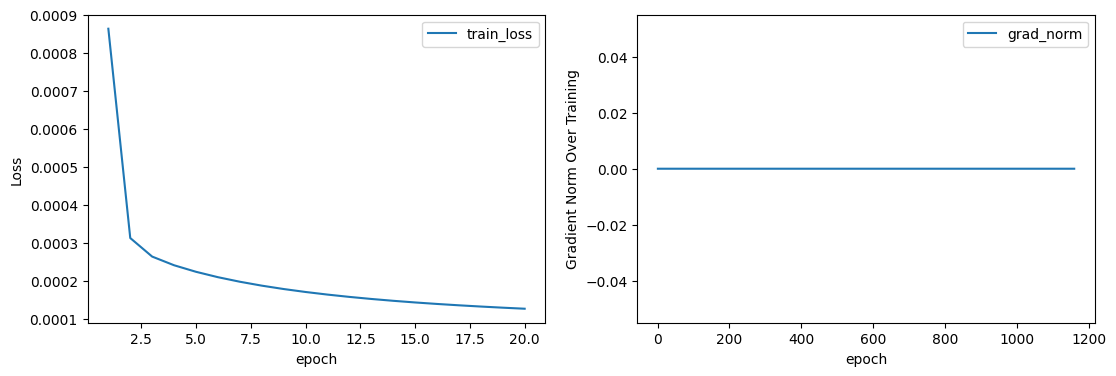

Loss: 0.0001: 100%|██████████| 20/20 [00:02<00:00,  8.02it/s]


In [9]:
from tqdm import tqdm

grad_norms = []
train_losses = []
for epoch in (pbar := tqdm(range(N_EPOCHS))):
    train_loss = 0.0
    pred_path = []
    model.train()
    for features, labels in train_loader:
        optimizer.zero_grad()

        features = features.to(device)
        labels = labels.to(device)

        pred = model(features)

        loss = criterion(pred, labels)
        # true_balance = labels.mean().item()
        # acc = (pred.detach().argmax(axis=1) == labels).to(torch.float32).mean().item()

        total_norm = 0
        for p in model.parameters():
            if p.grad is not None:
                param_norm = p.grad.norm().item()
                total_norm += param_norm**2
        total_norm = total_norm**0.5
        grad_norms.append(total_norm)

        loss.backward()
        optimizer.step()

        # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=max_grad_norm)

        train_loss += loss.item()

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    # scheduler.step()
    # pbar.set_description(f"Loss: {train_loss:.4f}, Accuracy: {acc:.4f}, True Balance: {true_balance:.4f}")
    pbar.set_description(f"Loss: {train_loss:.4f}")
    plot_losses(train_losses, grad_norms)

In [10]:
model.eval()
preds = []
for features, labels in train_loader:
    features = features.to(device)
    labels = labels.to(device)

    pred = model(features).detach().cpu().numpy()
    preds.append(pred)

In [11]:
from sklearn.metrics import r2_score

r2_score(y.cpu(), np.concat(preds).reshape(-1))

-0.4017174243927002

In [12]:
y

tensor([[0.0197],
        [0.0394],
        [0.0527],
        ...,
        [0.0481],
        [0.0601],
        [0.0684]])

In [13]:
preds

[array([[0.05177446],
        [0.0440913 ],
        [0.03167615],
        [0.05299029],
        [0.05462708],
        [0.03858837],
        [0.02809154],
        [0.0520649 ],
        [0.04574098],
        [0.05342479],
        [0.06160726],
        [0.03269845],
        [0.08469335],
        [0.04593549],
        [0.04536887],
        [0.05320887],
        [0.04853452],
        [0.05494743],
        [0.05484004],
        [0.0546705 ],
        [0.04090598],
        [0.052772  ],
        [0.06830668],
        [0.06860902],
        [0.04960714],
        [0.04305302],
        [0.01887201],
        [0.11570349],
        [0.00379239],
        [0.08959436],
        [0.04361574],
        [0.0487538 ]], dtype=float32),
 array([[0.0477143 ],
        [0.04786525],
        [0.03594837],
        [0.05482598],
        [0.04999475],
        [0.05534614],
        [0.02877813],
        [0.0554198 ],
        [0.08292429],
        [0.04881884],
        [0.09102529],
        [0.03961727],
        [0.0417